In [1]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 123.2 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import glob
import random
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [18]:
def load_images_from_folder(folder_path):
    # glob finds the images
    png_paths = glob.glob(os.path.join(folder_path, "*.png"))
    images = []
    for path in png_paths:
        img = Image.open(path).convert("RGB")  # ensure 3-channel
        images.append(np.array(img, dtype=np.float32))
    return images

In [6]:
def random_augmentations(img, num_augmented=10, output_folder=None):

    #unpacking numpy array shape
    H, W, C = img.shape
    augmented_images = []
    
    for i in range(num_augmented):
        # 2a. Random rotation
        angle = random.uniform(-25, 25)  # degrees
        M_rot = cv2.getRotationMatrix2D((W/2, H/2), angle, 1.0)
        
        # 2b. Random scale
        scale = random.uniform(0.8, 1.2)
        M_rot[0,0] *= scale
        M_rot[1,1] *= scale
        
        # Apply rotation+scale
        transformed = cv2.warpAffine(img, M_rot, (W, H),
                                     flags=cv2.INTER_LINEAR,
                                     borderMode=cv2.BORDER_REPLICATE)
        
        # 2c. Random shift
        shift_x = random.uniform(-0.1, 0.1) * W
        shift_y = random.uniform(-0.1, 0.1) * H
        M_shift = np.float32([[1, 0, shift_x],
                              [0, 1, shift_y]])
        transformed = cv2.warpAffine(transformed, M_shift, (W, H),
                                     flags=cv2.INTER_LINEAR,
                                     borderMode=cv2.BORDER_REFLECT_101)
        
        # 2d. Random warp
        margin = 0.1  # fraction of width/height to deviate
        pts1 = np.float32([[0, 0],
                           [W, 0],
                           [0, H],
                           [W, H]])
        pts2 = np.float32([
            [random.uniform(0, margin*W),       random.uniform(0, margin*H)],
            [W - random.uniform(0, margin*W),   random.uniform(0, margin*H)],
            [random.uniform(0, margin*W),       H - random.uniform(0, margin*H)],
            [W - random.uniform(0, margin*W),   H - random.uniform(0, margin*H)]
        ])
        M_persp = cv2.getPerspectiveTransform(pts1, pts2)
        transformed = cv2.warpPerspective(transformed, M_persp, (W, H),
                                          flags=cv2.INTER_LINEAR,
                                          borderMode=cv2.BORDER_REFLECT_101)
        
        augmented_images.append(transformed)
        
        # Save
        if output_folder:
            if not os.path.exists(output_folder):
                os.makedirs(output_folder, exist_ok=True)
            filename = f"aug_{i}.png"
            outpath = os.path.join(output_folder, filename)
            cv2.imwrite(outpath, transformed.astype(np.uint8))
    
    return augmented_images

In [10]:
def extract_patches(imgs, patch_size=(32, 32), num_patches_per_image=5):

    patches = []
    ps_h, ps_w = patch_size
    for idx, img in enumerate(imgs):
        H, W, C = img.shape
        # If the image is too small for the patch size, skip or handle accordingly
        if H < ps_h or W < ps_w:
            print(f"Warning: Image {idx} has shape {img.shape}, "
                  f"smaller than patch size {patch_size}. Skipping.")
            continue
        
        for _ in range(num_patches_per_image):
            y = random.randint(0, H - ps_h)
            x = random.randint(0, W - ps_w)
            patch = img[y:y+ps_h, x:x+ps_w, :]
            patches.append(patch)
    return patches

In [13]:
def compute_zca_whitening(patches, epsilon=1e-5):
    """
    Applies ZCA whitening to a list (or array) of patches.
    Returns whitened patches as (N, h, w, c).
    """
    # Convert to array -> shape (N, h, w, c)
    patches_array = np.array(patches)
    print("ZCA: patches_array.shape =", patches_array.shape)
    
    if len(patches_array) == 0:
        print("No patches to whiten. Returning empty array.")
        return patches_array
    
    if patches_array.ndim != 4:
        raise ValueError("patches_array is not the expected shape (N, h, w, c). "
                         f"Got {patches_array.shape}.")
    
    N, h, w, c = patches_array.shape
    D = h * w * c
    
    # Reshape to (N, D)
    patches_reshaped = patches_array.reshape(N, D)
    
    # Center
    mean = np.mean(patches_reshaped, axis=0)
    centered = patches_reshaped - mean
    
    # Covariance
    cov = np.cov(centered, rowvar=False)  # shape (D, D)
    
    # SVD
    U, S, Vt = np.linalg.svd(cov)
    
    # ZCA matrix
    zca_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    
    # Whiten
    whitened = centered @ zca_matrix
    
    # Reshape to original
    whitened_reshaped = whitened.reshape(N, h, w, c)
    return whitened_reshaped

In [14]:
def compute_channel_statistics(images):
    """
    Compute mean and std for each channel across a list/array of images.
    Return: (channel_means, channel_stds)
    """
    arr = np.array(images)
    if arr.ndim != 4:
        raise ValueError("Expected (N, h, w, c) data, got shape:", arr.shape)

    channel_means = np.mean(arr, axis=(0, 1, 2))
    channel_stds  = np.std(arr, axis=(0, 1, 2))
    return channel_means, channel_stds

In [19]:
# insert folder with images 
folder_with_leaf_images = "/home/exouser/ME592_HW2/leaves"

In [20]:
# 1. LOAD IMAGES
images = load_images_from_folder(folder_with_leaf_images)
print(f"Loaded {len(images)} images.")

Loaded 8 images.


In [7]:
# 2. Augmentation
if images:
    example_img = images[0]
    augmented_images = random_augmentations(
        example_img,
        num_augmented=100,
        output_folder="/home/exouser/ME592_HW2/AugmentedImages"
    )
    print(f"Augmented {len(augmented_images)} images.")

Augmented 100 images.


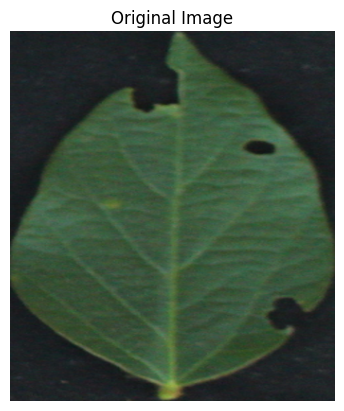

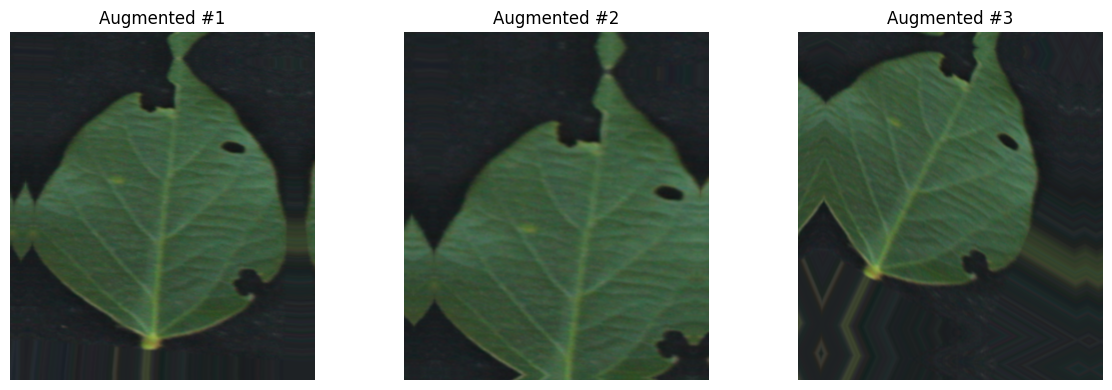

In [21]:
# Show the original
plt.figure()
plt.imshow(example_img.astype("uint8"))
plt.title("Original Image")
plt.axis("off")
plt.show()

# Now show a few augmented images
num_to_show = 3  # how many augmented images to display
plt.figure(figsize=(12, 4))
for i in range(num_to_show):
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.title(f"Augmented #{i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# 3. EXTRACT PATCHES
patch_size = (32, 32)
all_patches = extract_patches(images, patch_size=patch_size, num_patches_per_image=5)
print("Total patches extracted:", len(all_patches))

Total patches extracted: 40


Total patches extracted: 40


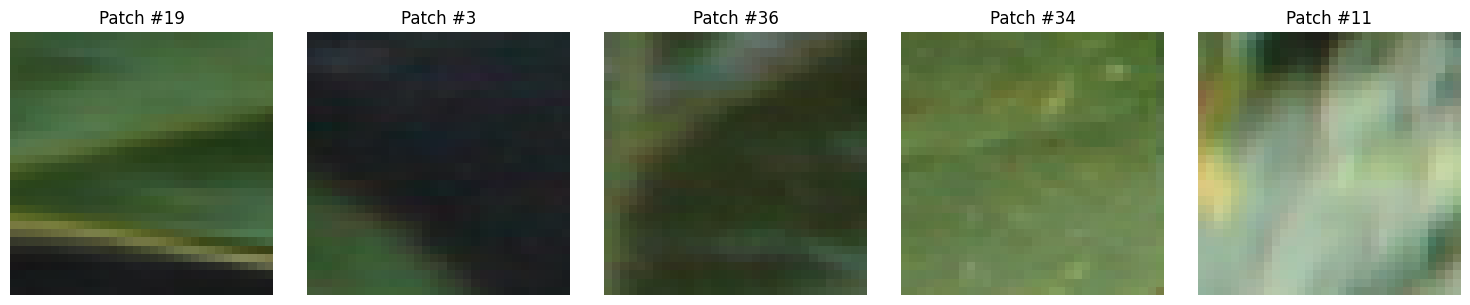

In [22]:
print(f"Total patches extracted: {len(all_patches)}")

# Let's randomly choose 5 patches to show
num_to_show = 5
random_indices = random.sample(range(len(all_patches)), k=min(num_to_show, len(all_patches)))

# Create a figure with one row and up to 5 columns for patches
plt.figure(figsize=(15, 3))

for i, idx in enumerate(random_indices):
    plt.subplot(1, num_to_show, i + 1)
    patch_display = all_patches[idx].astype("uint8")
    plt.imshow(patch_display)
    plt.title(f"Patch #{idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [23]:
 # 4. PREWHITEN (ZCA)
zca_whitened_patches = compute_zca_whitening(all_patches, epsilon=1e-5)

ZCA: patches_array.shape = (40, 32, 32, 3)


In [24]:
 # 5. CHANNEL STATISTICS
if len(all_patches) > 0:
    orig_means, orig_stds = compute_channel_statistics(all_patches)
    print("Original Patch Channel Means:", orig_means)
    print("Original Patch Channel STDs: ", orig_stds)

Original Patch Channel Means: [64.19981  80.453026 56.03701 ]
Original Patch Channel STDs:  [39.56401  46.626293 32.11717 ]


ZCA-Whitened Patch Channel Means: [-1.45842897e-06  2.70857707e-06 -3.86209073e-06]
ZCA-Whitened Patch Channel STDs:  [0.11249004 0.11656537 0.10437014]


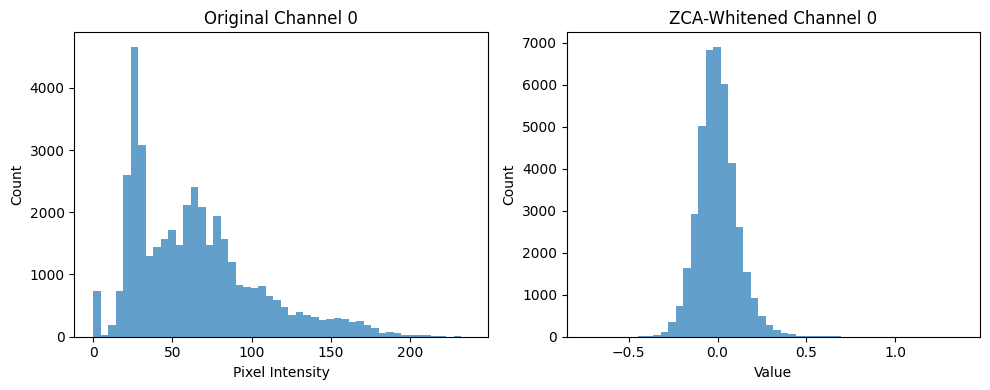

In [25]:
if len(zca_whitened_patches) > 0:
    zca_means, zca_stds = compute_channel_statistics(zca_whitened_patches)
    print("ZCA-Whitened Patch Channel Means:", zca_means)
    print("ZCA-Whitened Patch Channel STDs: ", zca_stds)

    orig_ch0 = np.array(all_patches)[..., 0].ravel()
    zca_ch0  = zca_whitened_patches[..., 0].ravel()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Left subplot: Original channel 0
    axes[0].hist(orig_ch0, bins=50, alpha=0.7)
    axes[0].set_title("Original Channel 0")
    axes[0].set_xlabel("Pixel Intensity")
    axes[0].set_ylabel("Count")

    # Right subplot: ZCA channel 0
    axes[1].hist(zca_ch0, bins=50, alpha=0.7)
    axes[1].set_title("ZCA‐Whitened Channel 0")
    axes[1].set_xlabel("Value")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()